In [1]:
%matplotlib inline

In [11]:
#!/usr/bin/env python

# --------------------------------------------------------
# Faster R-CNN
# Copyright (c) 2015 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# Written by Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""

#import os
#os.chdir("/root/pva-faster-rcnn/")
from pycocotools.coco import COCO
import glob
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list


def _get_ann_file():
        prefix = 'image_info' 
        return os.path.join("/root/data/coco/", 'annotations',
                        prefix + '_' + "test2014" + '.json')

    
    
COCO = COCO(_get_ann_file())
cats = COCO.loadCats(COCO.getCatIds())
CLASSES  = tuple(['__background__'] + [c['name'] for c in cats])


print(CLASSES)



loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
('__background__', u'person', u'bicycle', u'car', u'motorcycle', u'airplane', u'bus', u'train', u'truck', u'boat', u'traffic light', u'fire hydrant', u'stop sign', u'parking meter', u'bench', u'bird', u'cat', u'dog', u'horse', u'sheep', u'cow', u'elephant', u'bear', u'zebra', u'giraffe', u'backpack', u'umbrella', u'handbag', u'tie', u'suitcase', u'frisbee', u'skis', u'snowboard', u'sports ball', u'kite', u'baseball bat', u'baseball glove', u'skateboard', u'surfboard', u'tennis racket', u'bottle', u'wine glass', u'cup', u'fork', u'knife', u'spoon', u'bowl', u'banana', u'apple', u'sandwich', u'orange', u'broccoli', u'carrot', u'hot dog', u'pizza', u'donut', u'cake', u'chair', u'couch', u'potted plant', u'bed', u'dining table', u'toilet', u'tv', u'laptop', u'mouse', u'remote', u'keyboard', u'cell phone', u'microwave', u'oven', u'toaster', u'sink', u'refrigerator', u'book', u'clock', u'vase', u'scissors', u'



Loaded network ../models/coco/VGG16/faster_rcnn_end2end/coco_vgg16_faster_rcnn_final.caffemodel?dl=0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/071008_luggage_hmed_12p.grid-6x2.jpg
(339, 474, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/bu_luggage23_0030_lm.jpg
(494, 324, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/men-carrying-too-much-carryon-luggage.jpg
(315, 225, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/shutterstock_128647436.jpg
(3813, 5517, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/carry-onluggage.jpg
(305, 480, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo//root/data/demo/suitcase/tips-packing-light-tourists-luggage.jpg
(797, 600, 3)


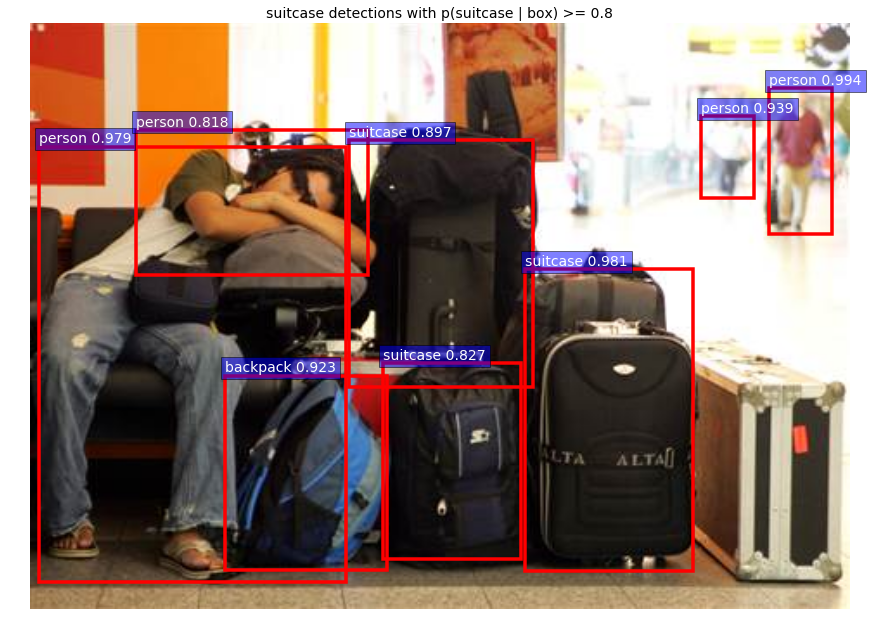

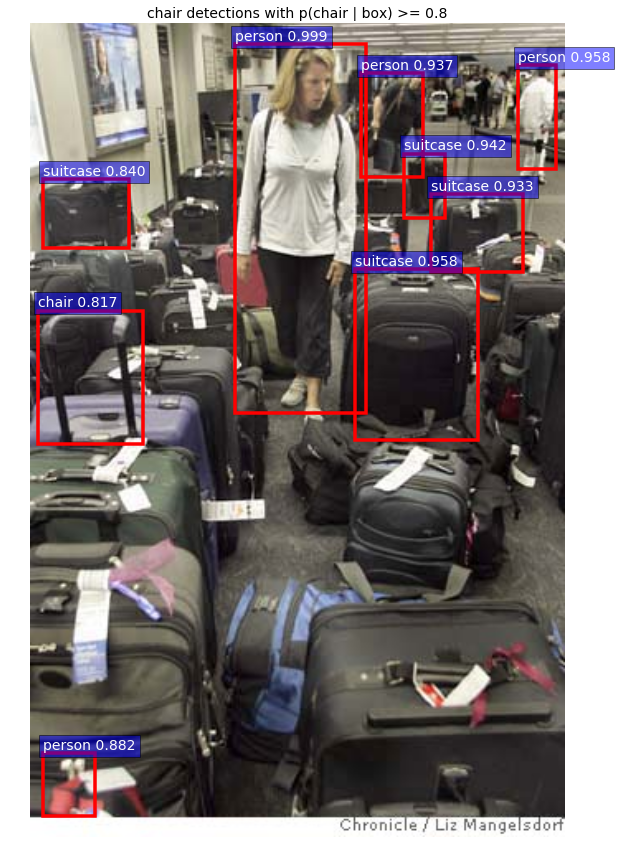

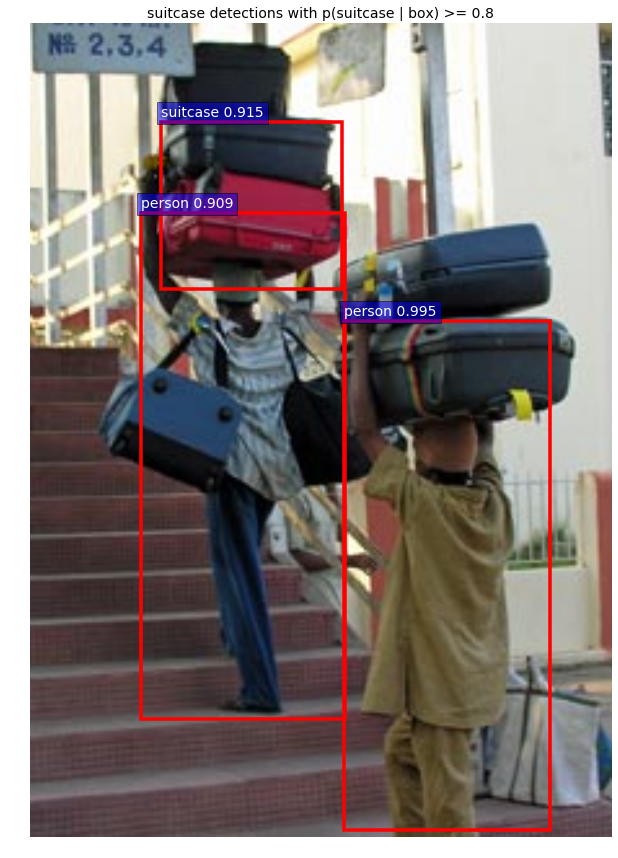

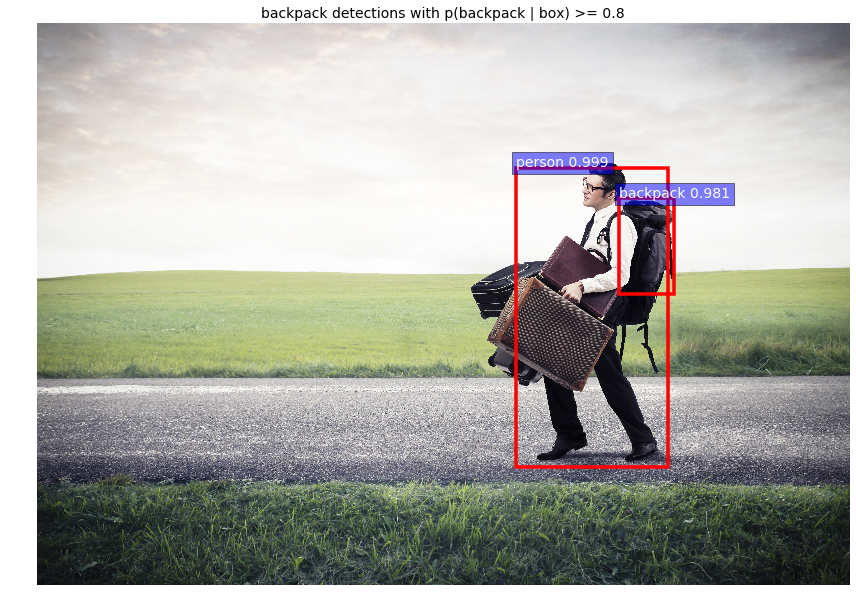

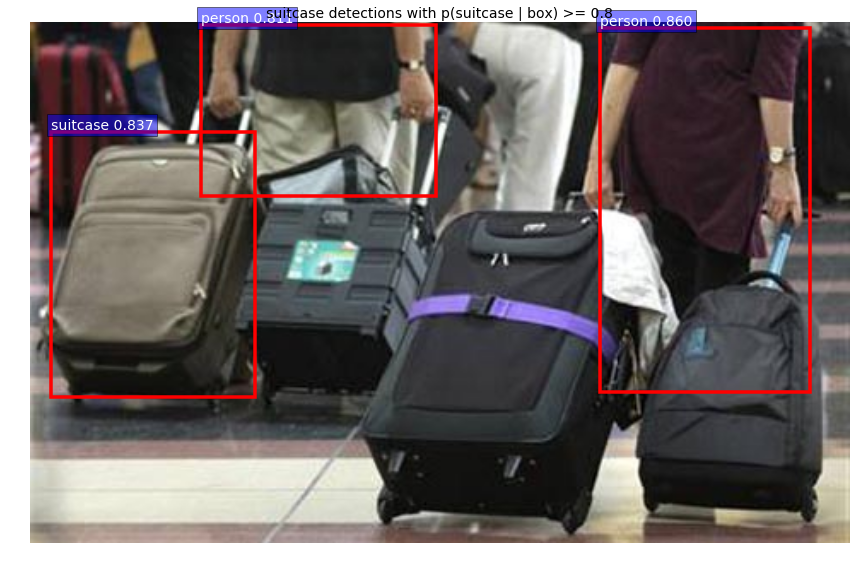

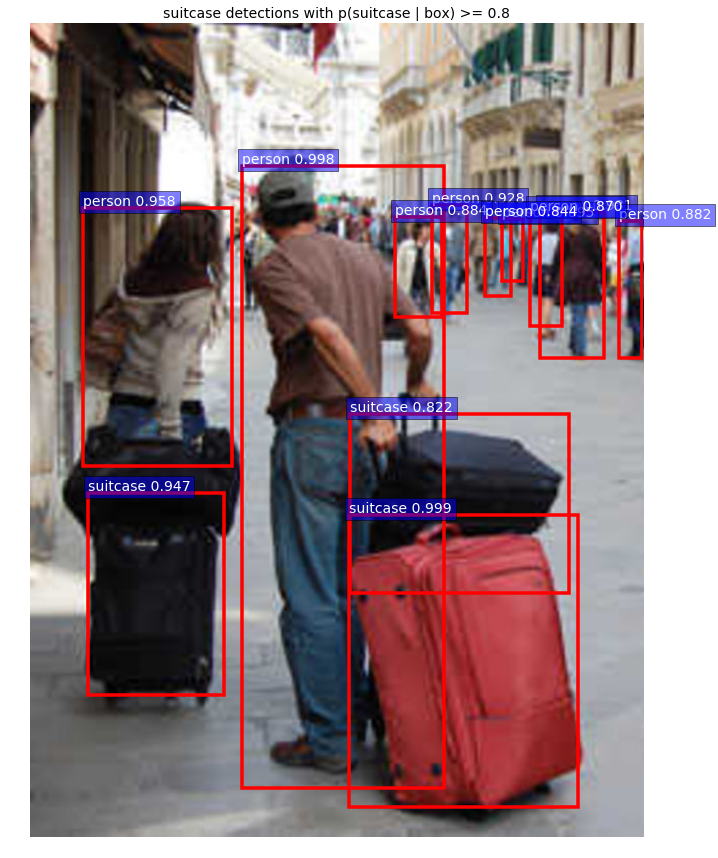

In [13]:


def vis_detections(im, class_names, dets_list, thresh=0.5):
    """Draw detected bounding boxes."""
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    
    for class_name, dets in zip(class_names, dets_list):

        inds = np.where(dets[:, -1] >= thresh)[0]
        if len(inds) == 0:
            continue


        for i in inds:
            bbox = dets[i, :4]
            score = dets[i, -1]

            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='red', linewidth=3.5)
                )
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s} {:.3f}'.format(class_name, score),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

        ax.set_title(('{} detections with '
                      'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                      thresh),
                      fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

def demo(net, im_file):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
   
    im = cv2.imread(im_file)
    print(im.shape)
    #int("Hallo")
    

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    _t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
    scores, boxes = im_detect(net, im, _t)
    timer.toc()
    #print ('Detection took {:.3f}s for '
           #'{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.8
    NMS_THRESH = 0.3
    
    cls_list = []
    dets_list = []
    
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        
        cls_list.append(cls)
        dets_list.append(dets)
        
        
    vis_detections(im, cls_list, dets_list, thresh=CONF_THRESH)



if __name__ == '__main__':
    cfg.TEST.HAS_RPN = True
   

    prototxt = "../models/coco/VGG16/faster_rcnn_end2end/test.prototxt"
    caffemodel = "../models/coco/VGG16/faster_rcnn_end2end/coco_vgg16_faster_rcnn_final.caffemodel?dl=0"

    caffe.set_mode_gpu()
    caffe.set_device(3)
    cfg.GPU_ID = 3
    net = caffe.Net(prototxt, caffemodel, caffe.TEST)

    print '\n\nLoaded network {:s}'.format(caffemodel)

    # Warmup on a dummy image
    #m = 128 * np.ones((300, 500, 3), dtype=np.uint8)
    #for i in xrange(2):
        #_t = {'im_preproc': Timer(), 'im_net' : Timer(), 'im_postproc': Timer(), 'misc' : Timer()}
        #_, _= im_detect(net, im, _t)
    '''
    im_names = ['/root/data/data-HighwayDay/images/set00/V000/set00_V000_689.jpg',\
                '/root/data/data-HighwayDay/images/set00/V000/set00_V000_789.jpg',\
                '/root/data/data-HighwayDay/images/set00/V000/set00_V000_889.jpg',\
                '/root/data/data-HighwayDay/images/set00/V000/set00_V000_989.jpg',\
                '/root/data/data-HighwayDay/images/set00/V000/set00_V000_1089.jpg']
    '''
    
    im_names = glob.glob("/root/data/demo/suitcase/*.jpg")
    
    
    for im_name in im_names:
        print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
        print 'Demo for data/demo/{}'.format(im_name)
        demo(net, im_name)

    plt.show()


u'/root/py-faster-rcnn/tools'